# United States Gun Background Check and Census Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#sources">Sources</a></li>
</ul>

<a id='intro'></a>
## Introduction

This analysis looks at data from two sources. The first is the FBI's National Instant Criminal Background Check System (NICS). Whenever an individual wants to undergo a transaction involving firearms or explosives, Federal Firearms Licensees (FFLs) have to input a background check into the system in order to make sure that the individual is eligible to complete the transaction. The data not only includes gun sales, but also other transactions such as concealed carry permits, rentals, private sales, and so on.

The other data comes from the US census and provides statistics by state for a variety of metrics. Most of this data is from the time period between 2010 and 2016.

In this analysis, I will combine these two data sources to look at the relationship between gun background checks and demographic data. First, I will show the overall trend of background checks and gun sales over the time period represented by the data. Additionally, I would like to zoom in specifically on handgun, long gun, and multiple-gun sales to see if the frequency of these particular transactions have changed over time. Next, I am curious about which states have the most total background checks, as well as which states are growing the fastest in this area. Finally, I would like to see the general demographic profile of states with higher background checks. In particular, I will focus on race, veteran status, immigrant status, education, income, and population density.

Here are the questions I will answer in this analysis:
- What is the overall trend of background checks and gun sales?
- What is the overall trend of background checks split by gun category?
- Which states have had the largest overall and largest growth in background checks per capita?
- What demographic data correlates with background checks per capita by state?

To begin my analysis, I will download the necessary packages, including Numpy, Pandas, Matplotlib, Seaborn, and Scipy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import seaborn as sb
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

<a id='wrangling'></a>
## Data Wrangling

### General Properties

The NICS and census data was provided in a zip file containing `'gun_data.xlsx'` and `'U.S. Census Data.csv'`. I have converted `'gun_data.xlsx'` to a CSV file called `'gun_data.csv'` so that I can easily use Pandas to load in the NICS data.

In [2]:
gun_df = pd.read_csv('gun_data.csv')
census_df = pd.read_csv('U.S. Census Data.csv')

Below, I will perform a few operations to familiarize myself with the data and to see what data cleaning I might need to do. The function below will print out the shape, duplicated values, column data types, and missing values for each dataframe.

In [3]:
def print_properties(df):
    '''
    INPUT:
    df (DataFrame) - dataframe for which to output properties
    OUTPUT:
    None
    
    Print general properties for the dataframe, including the shape, number of duplicated rows,
    data types and missing values for each column, and descriptive statistics for numeric columns.
    '''
    
    print('Shape: {}'.format(df.shape))
    print('\n')
    print('Number of duplicated rows: {}'.format(sum(df.duplicated())))
    print('\n')
    # data types and number of missing values for each column
    print(df.info())
    print('\n')

In [4]:
gun_df.head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,prepawn_long_gun,prepawn_other,redemption_handgun,redemption_long_gun,redemption_other,returned_handgun,returned_long_gun,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,21.0,2.0,1378.0,1262.0,1.0,0.0,0.0,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,2.0,0.0,200.0,154.0,2.0,28.0,30.0,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,6.0,0.0,1474.0,748.0,3.0,82.0,5.0,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394
3,2017-09,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,13.0,0.0,1296.0,1824.0,4.0,0.0,0.0,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,0.0,0.0,535.0,397.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506


In [5]:
print_properties(gun_df)

Shape: (12485, 27)


Number of duplicated rows: 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   month                      12485 non-null  object 
 1   state                      12485 non-null  object 
 2   permit                     12461 non-null  float64
 3   permit_recheck             1100 non-null   float64
 4   handgun                    12465 non-null  float64
 5   long_gun                   12466 non-null  float64
 6   other                      5500 non-null   float64
 7   multiple                   12485 non-null  int64  
 8   admin                      12462 non-null  float64
 9   prepawn_handgun            10542 non-null  float64
 10  prepawn_long_gun           10540 non-null  float64
 11  prepawn_other              5115 non-null   float64
 12  redemption_handgun         10545 non-null  float64

After looking at the information for `gun_df`, I see a few issues that should be fixed:
- Most of the numeric columns have the data type float, except for `multiple` and `totals`. These two columns should be converted for consistency with the other columns. Additionally, it could possibly make operations more efficient later in the analysis.
- The `month` column data type should be converted to datetime.

I also notice that most of the columns except for `month`, `state`, `multiple`, and `totals` have missing values. I am not concerned about this as certain categories may not have any transactions for a given month. Every row should at least have a `month`, `state`, and `totals`; as long as those columns are fine, I do not think I need to drop any rows based on null values. However, I could impute these missing values with 0 in case I need to perform any operations on columns with nulls.

I will also look at the descriptive statistics for `gun_df`.

In [6]:
gun_df.describe()

,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,prepawn_long_gun,prepawn_other,redemption_handgun,redemption_long_gun,redemption_other,returned_handgun,returned_long_gun,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
count,12461.000000,1100.000000,12465.000000,12466.000000,5500.000000,12485.000000,12462.000000,10542.000000,10540.000000,5115.000000,10545.000000,10544.000000,5115.000000,2200.000000,2145.000000,1815.000000,990.000000,825.000000,2750.000000,2750.000000,2750.000000,2475.000000,2750.000000,2255.000000,12485.000000
mean,6413.629404,1165.956364,5940.881107,7810.847585,360.471636,268.603364,58.898090,4.828021,7.834156,0.165591,407.970413,599.332417,1.815249,29.612727,7.557576,1.027548,0.076768,0.087273,14.936000,11.602909,1.030182,0.402020,0.441818,0.105987,21595.725911
std,23752.338269,9224.200609,8618.584060,9309.846140,1349.478273,783.185073,604.814818,10.907756,16.468028,1.057105,783.467053,952.144809,4.574641,81.943020,22.097046,4.386296,0.634503,0.671649,71.216021,54.253090,4.467843,1.446568,1.528223,0.427363,32591.418387
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,865.000000,2078.250000,17.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4638.000000
50%,518.000000,0.000000,3059.000000,5122.000000,121.000000,125.000000,0.000000,0.000000,1.000000,0.000000,39.000000,175.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12399.000000
75%,4272.000000,0.000000,7280.000000,10380.750000,354.000000,301.000000,0.000000,5.000000,8.000000,0.000000,561.000000,872.000000,2.000000,16.000000,4.000000,0.000000,0.000000,0.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,25453.000000
max,522188.000000,116681.000000,107224.000000,108058.000000,77929.000000,38907.000000,28083.000000,164.000000,269.000000,49.000000,10046.000000,8831.000000,79.000000,603.000000,168.000000,64.000000,12.000000,12.000000,1017.000000,777.000000,71.000000,28.000000,17.000000,4.000000,541978.000000


The summary statistics look fine to me. None of the minimum values are less than 0, and none of the percentiles have values that are larger than the max in `totals`.

Now I will examine `census_df`.

In [7]:
census_df.head()

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",NaN,"4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065","20,612,439","10,310,371","1,428,557","1,683,140","12,801,539","6,633,053","3,134,693","2,907,289","4,436,974","4,681,666","1,331,479","6,016,447","6,811,779","9,928,300","5,519,952","2,988,726","6,093,000","1,042,520","1,907,116","2,940,058","1,334,795","8,944,469",2081015,19745289,10146788,757952,11614373,3923561,4093465,12784227,1056426,4961119,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
1,"Population estimates base, April 1, 2010, (V2016)",NaN,"4,780,131","710,249","6,392,301","2,916,025","37,254,522","5,029,324","3,574,114","897,936","18,804,592","9,688,680","1,360,301","1,567,650","12,831,574","6,484,136","3,046,869","2,853,129","4,339,344","4,533,479","1,328,364","5,773,786","6,547,813","9,884,129","5,303,924","2,968,103","5,988,928","989,414","1,826,334","2,700,691","1,316,461","8,791,953",2059198,19378110,9535688,672591,11536727,3751615,3831072,12702857,1052940,4625410,814195,6346298,"25,146,100","2,763,888","625,741","8,001,041","6,724,545","1,853,011","5,687,289","563,767"
2,"Population, percent change - April 1, 2010 (estimates base) to July 1, 2016, (V2016)",NaN,1.70%,4.50%,8.40%,2.50%,5.40%,10.20%,0.10%,6.00%,9.60%,6.40%,5.00%,7.40%,-0.20%,2.30%,2.90%,1.90%,2.20%,3.30%,0.20%,4.20%,4.00%,0.40%,4.10%,0.70%,1.70%,5.40%,4.40%,8.90%,1.40%,1.70%,0.011,0.019,0.064,0.127,0.007,0.046,0.068,0.006,0.003,0.073,0.063,0.048,10.80%,10.40%,-0.20%,5.10%,8.40%,-1.20%,1.60%,3.90%
3,"Population, Census, April 1, 2010",NaN,"4,779,736","710,231","6,392,017","2,915,918","37,253,956","5,029,196","3,574,097","897,934","18,801,310","9,687,653","1,360,301","1,567,582","12,830,632","6,483,802","3,046,355","2,853,118","4,339,367","4,533,372","1,328,361","5,773,552","6,547,629","9,883,640","5,303,925","2,967,297","5,988,927","989,415","1,826,341","2,700,551","1,316,470","8,791,894",2059179,19378102,9535483,672591,11536504,3751351,3831074,12702379,1052567,4625364,814180,6346105,"25,145,561","2,763,885","625,741","8,001,024","6,724,540","1,852,994","5,686,986","563,626"
4,"Persons under 5 years, percent, July 1, 2016, (V2016)",NaN,6.00%,7.30%,6.30%,6.40%,6.30%,6.10%,5.20%,5.80%,5.50%,6.40%,6.40%,6.80%,6.00%,6.40%,6.40%,6.70%,6.20%,6.60%,4.90%,6.10%,5.30%,5.80%,6.40%,6.30%,6.10%,6.00%,7.00%,6.30%,4.80%,5.80%,0.062,0.059,0.06,0.073,0.06,0.068,0.058,0.056,0.052,0.059,0.071,0.061,7.20%,8.30%,4.90%,6.10%,6.20%,5.50%,5.80%,6.50%


In [8]:
print_properties(census_df)

Shape: (85, 52)


Number of duplicated rows: 3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 52 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Fact            80 non-null     object
 1   Fact Note       28 non-null     object
 2   Alabama         65 non-null     object
 3   Alaska          65 non-null     object
 4   Arizona         65 non-null     object
 5   Arkansas        65 non-null     object
 6   California      65 non-null     object
 7   Colorado        65 non-null     object
 8   Connecticut     65 non-null     object
 9   Delaware        65 non-null     object
 10  Florida         65 non-null     object
 11  Georgia         65 non-null     object
 12  Hawaii          65 non-null     object
 13  Idaho           65 non-null     object
 14  Illinois        65 non-null     object
 15  Indiana         65 non-null     object
 16  Iowa            65 non-null     object
 17  Kansas 

I see several issues for `census_df`:
- The `Fact` column has 80 non-null values, while most of the remaining columns only have 65. That seems odd -- if a certain fact is given, I would expect at least one state to have data on that fact. `Fact Note` has many more missing values, but I would expect that given that not every `Fact` will have an explanation. I will explore rows with null values below.
- All of the data types are strings. Based on the `census_df.head()` statement above and after looking at the original CSV file, it looks like all of these columns should be converted to int or float, except for `FIPS Code`, which can probably be removed.
- This dataframe has the states as the columns and the facts as the rows. It might be worthwhile to switch the rows and columns in case I want to perform any merging using the state names.
- If I want to use the facts as the column names, I should shorten the column names to make them easier to use. I will do this after I drop irrelevant columns, so that I do not have to change the name of every single column.

To explore the rows with missing values, I will create a dataframe that drops `Fact Note`.

In [9]:
census_df_na = census_df.drop(['Fact Note'], axis=1)
# output any row that has a missing value
census_df_na[census_df_na.isna().any(axis=1)]

,Fact,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,NOTE: FIPS Code values are enclosed in quotes to ensure leading zeros remain intact.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,Value Notes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,Fact Notes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,(a),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,(b),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,(c),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
census_df.query('Fact == "FIPS Code"')

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
64,FIPS Code,NaN,"""01""","""02""","""04""","""05""","""06""","""08""","""09""","""10""","""12""","""13""","""15""","""16""","""17""","""18""","""19""","""20""","""21""","""22""","""23""","""24""","""25""","""26""","""27""","""28""","""29""","""30""","""31""","""32""","""33""","""34""","""35""","""36""","""37""","""38""","""39""","""40""","""41""","""42""","""44""","""45""","""46""","""47""","""48""","""49""","""50""","""51""","""53""","""54""","""55""","""56"""


The rows with missing values are just footnotes at the bottom of the dataframe. I will remove these rows in addition to `FIPS Code`.

I will also look into the duplicate rows below. Based on the output above, I suspect that some of the duplicate rows may be in the footnotes section.

In [11]:
census_df[census_df.duplicated()]

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Because these rows are in the footnotes area, I know that they will get cleaned up when I remove the footnotes.

I will not print the descriptive statistics for `census_df` at this point because I do not think it makes sense to look at the summary statistics across different metrics. Instead, I will wait until after I switch the rows and columns. This will allow me to make comparisons within the same metric across states.

Also, I am curious to see a comparison of which states are included in `gun_df` and which are included in `census_df`.

In [12]:
gun_df_states = pd.Series(gun_df['state'].unique())
census_df_states = pd.Series(census_df.columns[2:])

In [13]:
# states in gun_df not in census_df
gun_df_states[~gun_df_states.isin(census_df_states)]

8     District of Columbia
11                    Guam
21         Mariana Islands
41             Puerto Rico
49          Virgin Islands
dtype: object

In [14]:
# states in census_df not in gun_df
census_df_states[~census_df_states.isin(gun_df_states)]

Series([], dtype: object)

In order to make an equal comparison between the two datasets, I will drop rows in `gun_df` with the states listed above.

### Data Cleaning

Based on the exploration above, here are the steps I will need to take in data cleaning:

For `gun_df`:
- Change `multiple` and `totals` columns from int to float
- Change `month` column from string to datetime
- Impute missing values with 0
- Exclude rows for states in `['District of Columbia', 'Guam', 'Mariana Islands', 'Puerto Rico', 'Virgin Islands']`

For `census_df`:
- Drop footnotes section, rows 64-84
- Switch rows and columns
- Once rows and columns are switched, only keep columns that I plan to use
- Change column names to simpler formats
- Convert all values to float

First, I will convert the data types for `multiple`, `totals`, and `month` in `gun_df`.

In [15]:
gun_df['multiple'] = gun_df['multiple'].astype(float)
gun_df['totals'] = gun_df['totals'].astype(float)
gun_df['month'] = pd.to_datetime(gun_df['month'])

I also want to extract the year from the `month` column.

In [16]:
gun_df['year'] = gun_df['month'].dt.year

I will look at the dataframe info to see if the appropriate data type changes were made.

In [17]:
gun_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   month                      12485 non-null  datetime64[ns]
 1   state                      12485 non-null  object        
 2   permit                     12461 non-null  float64       
 3   permit_recheck             1100 non-null   float64       
 4   handgun                    12465 non-null  float64       
 5   long_gun                   12466 non-null  float64       
 6   other                      5500 non-null   float64       
 7   multiple                   12485 non-null  float64       
 8   admin                      12462 non-null  float64       
 9   prepawn_handgun            10542 non-null  float64       
 10  prepawn_long_gun           10540 non-null  float64       
 11  prepawn_other              5115 non-null   float64       
 12  rede

It looks like the new `year` column has the data type int, but I would like it to be datetime.

In [18]:
gun_df['year'] = pd.to_datetime(gun_df['year'], format='%Y')

In [19]:
gun_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   month                      12485 non-null  datetime64[ns]
 1   state                      12485 non-null  object        
 2   permit                     12461 non-null  float64       
 3   permit_recheck             1100 non-null   float64       
 4   handgun                    12465 non-null  float64       
 5   long_gun                   12466 non-null  float64       
 6   other                      5500 non-null   float64       
 7   multiple                   12485 non-null  float64       
 8   admin                      12462 non-null  float64       
 9   prepawn_handgun            10542 non-null  float64       
 10  prepawn_long_gun           10540 non-null  float64       
 11  prepawn_other              5115 non-null   float64       
 12  rede

Next I will impute missing values with 0.

In [20]:
gun_df.fillna(0, inplace=True)

There should be no more missing values when I look at the dataframe info again.

In [21]:
gun_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   month                      12485 non-null  datetime64[ns]
 1   state                      12485 non-null  object        
 2   permit                     12485 non-null  float64       
 3   permit_recheck             12485 non-null  float64       
 4   handgun                    12485 non-null  float64       
 5   long_gun                   12485 non-null  float64       
 6   other                      12485 non-null  float64       
 7   multiple                   12485 non-null  float64       
 8   admin                      12485 non-null  float64       
 9   prepawn_handgun            12485 non-null  float64       
 10  prepawn_long_gun           12485 non-null  float64       
 11  prepawn_other              12485 non-null  float64       
 12  rede

Now I will exclude rows with states in `['District of Columbia', 'Guam', 'Mariana Islands', 'Puerto Rico', 'Virgin Islands']`.

In [22]:
# states in gun_df not in census_df
drop_states = ['District of Columbia', 'Guam', 'Mariana Islands', 'Puerto Rico', 'Virgin Islands']
gun_df = gun_df.query('state not in @drop_states')

I will check the shape of the dataframe to see if rows were excluded.

In [23]:
gun_df.shape

(11350, 28)

For `census_df`, I will first drop the footnotes section.

In [24]:
# index of rows that are footnotes
drop_index = np.arange(64, len(census_df))
census_df.drop(drop_index, inplace=True)

I will check the shape of the dataframe to see if rows were dropped.

In [25]:
census_df.shape

(64, 52)

Next, I will switch the rows and columns.

In [26]:
# switch rows and columns
census_df = census_df.transpose()
census_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
Fact,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2016)","Population, percent change - April 1, 2010 (estimates base) to July 1, 2016, (V2016)","Population, Census, April 1, 2010","Persons under 5 years, percent, July 1, 2016, (V2016)","Persons under 5 years, percent, April 1, 2010","Persons under 18 years, percent, July 1, 2016, (V2016)","Persons under 18 years, percent, April 1, 2010","Persons 65 years and over, percent, July 1, 2016, (V2016)","Persons 65 years and over, percent, April 1, 2010","Female persons, percent, July 1, 2016, (V2016)","Female persons, percent, April 1, 2010","White alone, percent, July 1, 2016, (V2016)","Black or African American alone, percent, July 1, 2016, (V2016)","American Indian and Alaska Native alone, percent, July 1, 2016, (V2016)","Asian alone, percent, July 1, 2016, (V2016)","Native Hawaiian and Other Pacific Islander alone, percent, July 1, 2016, (V2016)","Two or More Races, percent, July 1, 2016, (V2016)","Hispanic or Latino, percent, July 1, 2016, (V2016)","White alone, not Hispanic or Latino, percent, July 1, 2016, (V2016)","Veterans, 2011-2015","Foreign born persons, percent, 2011-2015","Housing units, July 1, 2016, (V2016)","Housing units, April 1, 2010","Owner-occupied housing unit rate, 2011-2015","Median value of owner-occupied housing units, 2011-2015","Median selected monthly owner costs -with a mortgage, 2011-2015","Median selected monthly owner costs -without a mortgage, 2011-2015","Median gross rent, 2011-2015","Building permits, 2016","Households, 2011-2015","Persons per household, 2011-2015","Living in same house 1 year ago, percent of persons age 1 year+, 2011-2015","Language other than English spoken at home, percent of persons age 5 years+, 2011-2015","High school graduate or higher, percent of persons age 25 years+, 2011-2015","Bachelor's degree or higher, percent of persons age 25 years+, 2011-2015","With a disability, under age 65 years, percent, 2011-2015","Persons without health insurance, under age 65 years, percent","In civilian labor force, total, percent of population age 16 years+, 2011-2015","In civilian labor force, female, percent of population age 16 years+, 2011-2015","Total accommodation and food services sales, 2012 ($1,000)","Total health care and social assistance receipts/revenue, 2012 ($1,000)","Total manufacturers shipments, 2012 ($1,000)","Total merchant wholesaler sales, 2012 ($1,000)","Total retail sales, 2012 ($1,000)","Total retail sales per capita, 2012","Mean travel time to work (minutes), workers age 16 years+, 2011-2015","Median household income (in 2015 dollars), 2011-2015","Per capita income in past 12 months (in 2015 dollars), 2011-2015","Persons in poverty, percent","Total employer establishments, 2015","Total employment, 2015","Total annual payroll, 2015 ($1,000)","Total employment, percent change, 2014-2015","Total nonemployer establishments, 2015","All firms, 2012","Men-owned firms, 2012","Women-owned firms, 2012","Minority-owned firms, 2012","Nonminority-owned firms, 2012","Veteran-owned firms, 2012","Nonveteran-owned firms, 2012","Population per square mile, 2010","Land area in square miles, 2010"
Fact Note,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(a),(a),(a),(a),(a),NaN,(b),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(c),(c),(c),(c),(c),(c),NaN,NaN,NaN,NaN,Includes data not distributed by county.,Includes data not distributed by county.,Includes data not distributed by county.,Includes data not distributed by county.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alabama,"4,863,300","4,780,131",1.70%,"4,779,736",6.00%,6.40%,22.60%,23.70%,16.10%,13.80%,51.60%,51.50%,69.30%,26.80%,0.70%,1.40%,0.10%,1.60%,4.20%,65.80%,"363,170",3.50%,"2,230,185","2,171,853",68.70%,"$125

Now I will print a list of the column names to see the indices of columns that I want to keep, and then check the shape afterwards to see if it changed.

In [27]:
census_df.loc['Fact', :]

0                                               Population estimates, July 1, 2016,  (V2016)
1                                         Population estimates base, April 1, 2010,  (V2016)
2      Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)
3                                                          Population, Census, April 1, 2010
4                                     Persons under 5 years, percent, July 1, 2016,  (V2016)
5                                              Persons under 5 years, percent, April 1, 2010
6                                    Persons under 18 years, percent, July 1, 2016,  (V2016)
7                                             Persons under 18 years, percent, April 1, 2010
8                                Persons 65 years and over, percent,  July 1, 2016,  (V2016)
9                                          Persons 65 years and over, percent, April 1, 2010
10                                          Female persons, percent,  

In [28]:
# only keep certain column numbers
census_df = census_df.iloc[:, np.r_[:2, 12, 20:22, 34:36, 47:49, 62]]
census_df.shape

(52, 10)

In [29]:
census_df.head()

,0,1,12,20,21,34,35,47,48,62
Fact,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2016)","White alone, percent, July 1, 2016, (V2016)","Veterans, 2011-2015","Foreign born persons, percent, 2011-2015","High school graduate or higher, percent of persons age 25 years+, 2011-2015","Bachelor's degree or higher, percent of persons age 25 years+, 2011-2015","Median household income (in 2015 dollars), 2011-2015","Per capita income in past 12 months (in 2015 dollars), 2011-2015","Population per square mile, 2010"
Fact Note,NaN,NaN,(a),NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alabama,"4,863,300","4,780,131",69.30%,"363,170",3.50%,84.30%,23.50%,"$43,623","$24,091",94.4
Alaska,"741,894","710,249",66.10%,"69,323",7.40%,92.10%,28.00%,"$72,515","$33,413",1.2
Arizona,"6,931,071","6,392,301",83.30%,"505,794",13.50%,86.00%,27.50%,"$50,255","$25,848",56.3


Based on the output above, I also need to reset the index.

In [30]:
census_df.reset_index(inplace=True)
census_df.head()

,index,0,1,12,20,21,34,35,47,48,62
0,Fact,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2016)","White alone, percent, July 1, 2016, (V2016)","Veterans, 2011-2015","Foreign born persons, percent, 2011-2015","High school graduate or higher, percent of persons age 25 years+, 2011-2015","Bachelor's degree or higher, percent of persons age 25 years+, 2011-2015","Median household income (in 2015 dollars), 2011-2015","Per capita income in past 12 months (in 2015 dollars), 2011-2015","Population per square mile, 2010"
1,Fact Note,NaN,NaN,(a),NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,"4,863,300","4,780,131",69.30%,"363,170",3.50%,84.30%,23.50%,"$43,623","$24,091",94.4
3,Alaska,"741,894","710,249",66.10%,"69,323",7.40%,92.10%,28.00%,"$72,515","$33,413",1.2
4,Arizona,"6,931,071","6,392,301",83.30%,"505,794",13.50%,86.00%,27.50%,"$50,255","$25,848",56.3


I will now change the column names and then drop the first two rows so that only the state data remains. I will also save the first row as a data dictionary for how the columns are measured.

In [31]:
census_df.iloc[0, :]

index                                                                           Fact
0                                       Population estimates, July 1, 2016,  (V2016)
1                                 Population estimates base, April 1, 2010,  (V2016)
12                                      White alone, percent, July 1, 2016,  (V2016)
20                                                               Veterans, 2011-2015
21                                          Foreign born persons, percent, 2011-2015
34       High school graduate or higher, percent of persons age 25 years+, 2011-2015
35          Bachelor's degree or higher, percent of persons age 25 years+, 2011-2015
47                              Median household income (in 2015 dollars), 2011-2015
48                  Per capita income in past 12 months (in 2015 dollars), 2011-2015
62                                                  Population per square mile, 2010
Name: 0, dtype: object

In [32]:
census_df.columns = [
    'state',
    'population_2016',
    'population_2010',
    'white',
    'veterans',
    'immigrants',
    'hs_graduates',
    'bachelors_graduates',
    'median_income',
    'per_capita_income',
    'population_density'
]
census_df.head()

,state,population_2016,population_2010,white,veterans,immigrants,hs_graduates,bachelors_graduates,median_income,per_capita_income,population_density
0,Fact,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2016)","White alone, percent, July 1, 2016, (V2016)","Veterans, 2011-2015","Foreign born persons, percent, 2011-2015","High school graduate or higher, percent of persons age 25 years+, 2011-2015","Bachelor's degree or higher, percent of persons age 25 years+, 2011-2015","Median household income (in 2015 dollars), 2011-2015","Per capita income in past 12 months (in 2015 dollars), 2011-2015","Population per square mile, 2010"
1,Fact Note,NaN,NaN,(a),NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,"4,863,300","4,780,131",69.30%,"363,170",3.50%,84.30%,23.50%,"$43,623","$24,091",94.4
3,Alaska,"741,894","710,249",66.10%,"69,323",7.40%,92.10%,28.00%,"$72,515","$33,413",1.2
4,Arizona,"6,931,071","6,392,301",83.30%,"505,794",13.50%,86.00%,27.50%,"$50,255","$25,848",56.3


In [33]:
# data dictionary for census_df columns
census_df_dict = census_df.iloc[0, :]

In [34]:
# remove first 2 rows
census_df.drop([0, 1], inplace=True)
census_df.head()

,state,population_2016,population_2010,white,veterans,immigrants,hs_graduates,bachelors_graduates,median_income,per_capita_income,population_density
2,Alabama,"4,863,300","4,780,131",69.30%,"363,170",3.50%,84.30%,23.50%,"$43,623","$24,091",94.4
3,Alaska,"741,894","710,249",66.10%,"69,323",7.40%,92.10%,28.00%,"$72,515","$33,413",1.2
4,Arizona,"6,931,071","6,392,301",83.30%,"505,794",13.50%,86.00%,27.50%,"$50,255","$25,848",56.3
5,Arkansas,"2,988,248","2,916,025",79.40%,"220,953",4.70%,84.80%,21.10%,"$41,371","$22,798",56
6,California,"39,250,017","37,254,522",72.70%,"1,777,410",27.00%,81.80%,31.40%,"$61,818","$30,318",239.1


I notice that the index starts with 2 now so I will reset the index one more time.

In [35]:
census_df.reset_index(drop=True, inplace=True)
census_df.head()

,state,population_2016,population_2010,white,veterans,immigrants,hs_graduates,bachelors_graduates,median_income,per_capita_income,population_density
0,Alabama,"4,863,300","4,780,131",69.30%,"363,170",3.50%,84.30%,23.50%,"$43,623","$24,091",94.4
1,Alaska,"741,894","710,249",66.10%,"69,323",7.40%,92.10%,28.00%,"$72,515","$33,413",1.2
2,Arizona,"6,931,071","6,392,301",83.30%,"505,794",13.50%,86.00%,27.50%,"$50,255","$25,848",56.3
3,Arkansas,"2,988,248","2,916,025",79.40%,"220,953",4.70%,84.80%,21.10%,"$41,371","$22,798",56
4,California,"39,250,017","37,254,522",72.70%,"1,777,410",27.00%,81.80%,31.40%,"$61,818","$30,318",239.1


Finally, I will convert all values to data type float.

When I initially tried to convert the columns to float, I encountered errors saying that the strings could not be converted because of numeric symbols such as `,`, `$`, and `%`. I will take care of this by replacing these symbols with `''`.

However, when I convert percentages to float, I will have to treat them differently because the percentages should be divided by 100.

I will convert each value individually since a column might have different formats. For example, some percentages might have `%` at the end, while others might just show up as decimals.

In [36]:
# convert all columns in census_df except for state to float
for col in range(1, len(census_df.columns)):
    for row in range(len(census_df.index)):
        if census_df.iloc[row, col].endswith('%'):
            census_df.iloc[row, col] = float(census_df.iloc[row, col].replace('%', '')) / 100.
        else:
            census_df.iloc[row, col] = float(census_df.iloc[row, col].replace('$', '').replace(',', ''))

In [37]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   state                50 non-null     object
 1   population_2016      50 non-null     object
 2   population_2010      50 non-null     object
 3   white                50 non-null     object
 4   veterans             50 non-null     object
 5   immigrants           50 non-null     object
 6   hs_graduates         50 non-null     object
 7   bachelors_graduates  50 non-null     object
 8   median_income        50 non-null     object
 9   per_capita_income    50 non-null     object
 10  population_density   50 non-null     object
dtypes: object(11)
memory usage: 4.4+ KB


I notice that the data types still show as strings when I use the `info()` function. Therefore, I will use `pd.to_numeric()` to make sure that they are actually converted to floats.

In [38]:
for col in census_df.columns[1:]:
    census_df[col] = pd.to_numeric(census_df[col])

In [39]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state                50 non-null     object 
 1   population_2016      50 non-null     float64
 2   population_2010      50 non-null     float64
 3   white                50 non-null     float64
 4   veterans             50 non-null     float64
 5   immigrants           50 non-null     float64
 6   hs_graduates         50 non-null     float64
 7   bachelors_graduates  50 non-null     float64
 8   median_income        50 non-null     float64
 9   per_capita_income    50 non-null     float64
 10  population_density   50 non-null     float64
dtypes: float64(10), object(1)
memory usage: 4.4+ KB


All of the columns except for `state` have been converted to data type float. I can now print descriptive statistics to see if the `census_df` data looks reasonable.

In [40]:
census_df.describe()

,population_2016,population_2010,white,veterans,immigrants,hs_graduates,bachelors_graduates,median_income,per_capita_income,population_density
count,5.000000e+01,5.000000e+01,50.000000,5.000000e+01,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000
mean,6.448927e+06,6.163127e+06,0.793080,4.015940e+05,0.089620,0.882240,0.29012,54311.860000,28491.780000,194.962000
std,7.271769e+06,6.848463e+06,0.123359,3.831585e+05,0.060841,0.030896,0.04934,8949.529115,4103.284534,261.091465
min,5.855010e+05,5.637670e+05,0.258000,4.470800e+04,0.015000,0.818000,0.19200,39665.000000,21057.000000,1.200000
25%,1.850106e+06,1.833003e+06,0.724750,1.332715e+05,0.044000,0.856000,0.25950,47526.000000,25443.750000,44.450000
50%,4.559320e+06,4.436412e+06,0.821000,3.020175e+05,0.067500,0.888500,0.28200,52601.000000,27669.500000,98.750000
75%,7.198768e+06,6.680362e+06,0.875000,4.949490e+05,0.133750,0.908500,0.31775,60599.000000,30977.000000,209.500000
max,3.925002e+07,3.725452e+07,0.948000,1.777410e+06,0.270000,0.928000,0.40500,74551.000000,38803.000000,1195.500000


The `census_df` data looks ready for analysis, as there no unexpectedly high or low numbers.

<a id='eda'></a>
## Exploratory Data Analysis

### Question 1: What is the overall trend of background checks and gun sales?

To find the trend for background checks, I will utilize the `totals` column in `gun_df`. I will look at the overall trend for both yearly and monthly data in order to see the general trend over the years, as well as any trends within each year. 

I will start by adding columns to `gun_df` for gun sales. To calculate gun sales, I will use the methodology of the New York Times, as mentioned by Jeremy Singer-Vine of BuzzFeed News. With this methodology, each handgun and long gun background check counts as 1.1 sales, while a multiple-gun background check counts as two sales.

In [41]:
# convert background checks to sales according to New York Times methodology
gun_df['handgun_sales'] = gun_df['handgun'] * 1.1
gun_df['long_gun_sales'] = gun_df['long_gun'] * 1.1
gun_df['multiple_sales'] = gun_df['multiple'] * 2.
gun_df['total_sales'] = gun_df['handgun_sales'] + gun_df['long_gun_sales'] + gun_df['multiple_sales']
gun_df.head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,prepawn_long_gun,prepawn_other,redemption_handgun,redemption_long_gun,redemption_other,returned_handgun,returned_long_gun,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals,year,handgun_sales,long_gun_sales,multiple_sales,total_sales
0,2017-09-01,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317.0,0.0,15.0,21.0,2.0,1378.0,1262.0,1.0,0.0,0.0,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019.0,2017-01-01,6307.4,6952.0,634.0,13893.4
1,2017-09-01,Alaska,209.0,2.0,2320.0,2930.0,219.0,160.0,0.0,5.0,2.0,0.0,200.0,154.0,2.0,28.0,30.0,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303.0,2017-01-01,2552.0,3223.0,320.0,6095.0
2,2017-09-01,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631.0,0.0,13.0,6.0,0.0,1474.0,748.0,3.0,82.0,5.0,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394.0,2017-01-01,12169.3,8740.6,1262.0,22171.9
3,2017-09-01,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366.0,51.0,12.0,13.0,0.0,1296.0,1824.0,4.0,0.0,0.0,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747.0,2017-01-01,4781.7,6669.3,732.0,12183.0
4,2017-09-01,California,57839.0,0.0,37165.0,24581.0,2984.0,0.0,0.0,0.0,0.0,0.0,535.0,397.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506.0,2017-01-01,40881.5,27039.1,0.0,67920.6


Because full year data is not included for the first and last years (1998 and 2017, respectively), I will exclude those from the yearly view.

In [42]:
# only include full years
gun_df_full_years = gun_df.query('year >= "1999-01-01" & year <= "2016-12-31"')

In [43]:
total_checks_yearly = gun_df_full_years.groupby('year')['totals'].sum()
total_checks_yearly.head()

year
1999-01-01    9038315.0
2000-01-01    8421486.0
2001-01-01    8812457.0
2002-01-01    8358574.0
2003-01-01    8393942.0
Name: totals, dtype: float64

Before I create the graph, I will define a function to print the title, x-axis label, and y-axis label on each data visualization.

In [44]:
def plot_labels(title, xlabel, ylabel):
    '''
    INPUT:
    title (str) - title of the visualization
    xlabel (str) - x-axis label of the visualization
    ylabel (str) - y-axis label of the visualization
    OUTPUT:
    None
    
    Print the title, x-axis label, and y-axis label for a data visualization.
    '''
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

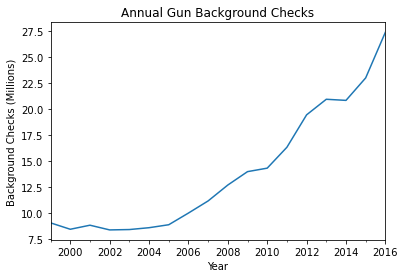

In [45]:
total_checks_yearly.plot()
total_checks_yearly_loc = np.arange(7500000, 30000000, 2500000)
plt.yticks(total_checks_yearly_loc, total_checks_yearly_loc/1000000)
plot_labels('Annual Gun Background Checks', 'Year', 'Background Checks (Millions)');

Based on this graph, it is clear that total annual background checks have increased since the data was first collected. In fact, the numbers have increased by about 20 million checks per year.

Next, I will show the monthly view for total background checks.

In [46]:
total_checks_monthly = gun_df.groupby('month')['totals'].sum()
total_checks_monthly.head()

month
1998-11-01     21174.0
1998-12-01    870202.0
1999-01-01    585569.0
1999-02-01    689867.0
1999-03-01    741234.0
Name: totals, dtype: float64

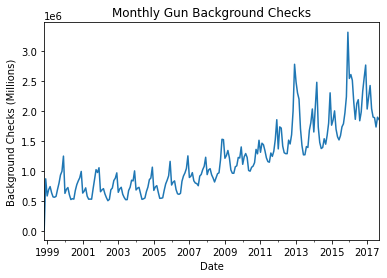

In [47]:
total_checks_monthly.plot()
plot_labels('Monthly Gun Background Checks', 'Date', 'Background Checks (Millions)');

The graph above also appears to show that background checks have been increasing since the data was first recorded. It is interesting to note that the increase has not been consistent rise over the years. Rather, it looks like there are cylical trends within each year, with background checks peaking towards the end of each year.

However, I will also look at the number of yearly background checks per capita to make sure that the increase in background checks is not simply due to an increase in population. Since I only have the total populations from 2010 and 2016, I will compare those two years.

Before I create the visualization, I will need to find the total background checks for 2010 and 2016 and the total population for those years.

In [48]:
gun_2010_2016 = gun_df.query('year == "2010-01-01" or year == "2016-01-01"')
# also include total_sales as this will be used later on
gun_totals_sales = gun_2010_2016.groupby(['state', 'year'], as_index=False)[['totals', 'total_sales']].sum()
gun_totals_sales['year'] = gun_totals_sales['year'].dt.year
gun_totals_sales.head()

,state,year,totals,total_sales
0,Alabama,2010,308607.0,289760.2
1,Alabama,2016,616947.0,315684.6
2,Alaska,2010,65909.0,67824.7
3,Alaska,2016,87647.0,86447.8
4,Arizona,2010,206050.0,181587.9


In [49]:
population = census_df[['state', 'population_2016', 'population_2010']]
# unpivot the data
population = pd.melt(population, id_vars='state', var_name='year', value_name='population')
population['year'] = population['year'].str[-4:].astype(int)
population.head()

,state,year,population
0,Alabama,2016,4863300.0
1,Alaska,2016,741894.0
2,Arizona,2016,6931071.0
3,Arkansas,2016,2988248.0
4,California,2016,39250017.0


I can now combine background checks and population into one dataset, calculate background checks per capita, and create the visualization.

In [50]:
per_capita = gun_totals_sales.merge(population, how='inner', on=['state', 'year'])
per_capita['checks_per_capita'] = per_capita['totals']/per_capita['population']
per_capita['sales_per_capita'] = per_capita['total_sales']/per_capita['population']
per_capita.head()

,state,year,totals,total_sales,population,checks_per_capita,sales_per_capita
0,Alabama,2010,308607.0,289760.2,4780131.0,0.064560,0.060618
1,Alabama,2016,616947.0,315684.6,4863300.0,0.126858,0.064912
2,Alaska,2010,65909.0,67824.7,710249.0,0.092797,0.095494
3,Alaska,2016,87647.0,86447.8,741894.0,0.118140,0.116523
4,Arizona,2010,206050.0,181587.9,6392301.0,0.032234,0.028407


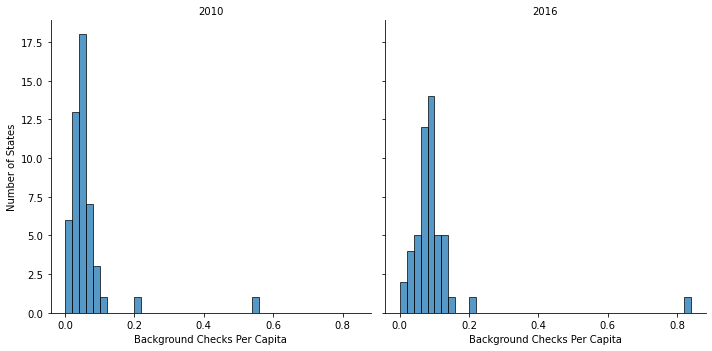

In [51]:
bin_size = 0.02
bins = np.arange(0, per_capita['checks_per_capita'].max()+bin_size, bin_size)
g = sb.displot(data=per_capita, x='checks_per_capita', col='year', bins=bins)
g.set_titles('{col_name}')
g.set_axis_labels('Background Checks Per Capita', 'Number of States');

The visualization confirms that, in general, the background checks per capita seem to have increased from 2010 to 2016, as the histogram for 2016 is less right-skewed than the one for 2010. It is also interesting to point out that there are a couple of noticeable outliers.

Now I will repeat the same process but with gun sales specifically. I will show the total number of gun sales by year and month, as well as gun sales per capita for 2010 and 2016.

In [52]:
gun_sales_yearly = gun_df_full_years.groupby('year')['total_sales'].sum()
gun_sales_yearly.head()

year
1999-01-01    8731052.1
2000-01-01    7854339.3
2001-01-01    8007430.8
2002-01-01    7056499.5
2003-01-01    7046706.5
Name: total_sales, dtype: float64

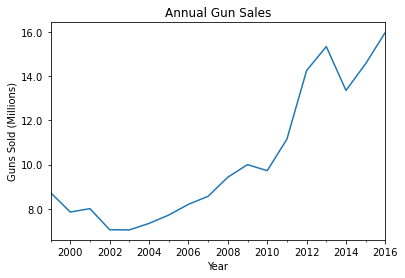

In [53]:
gun_sales_yearly.plot()
gun_sales_yearly_loc = np.arange(8000000, 18000000, 2000000)
plt.yticks(gun_sales_yearly_loc, gun_sales_yearly_loc/1000000)
plot_labels('Annual Gun Sales', 'Year', 'Guns Sold (Millions)');

Similar to total background checks, total gun sales have increased since the gun data was first collected. The annuals sales appear to have doubled since the beginning, going from around 8 million to 16 million sales per year.

In [54]:
gun_sales_monthly = gun_df.groupby('month')['total_sales'].sum()
gun_sales_monthly.head()

month
1998-11-01     21192.6
1998-12-01    878734.1
1999-01-01    558399.0
1999-02-01    661409.6
1999-03-01    698160.6
Name: total_sales, dtype: float64

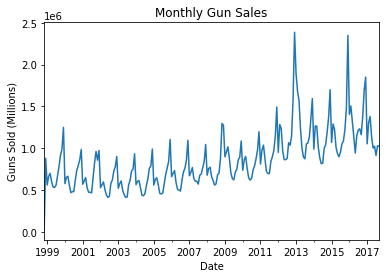

In [55]:
gun_sales_monthly.plot()
plot_labels('Monthly Gun Sales', 'Date', 'Guns Sold (Millions)');

The monthly gun sales show a similar trend as the monthly background checks, with sales peaking towards the end of each year.

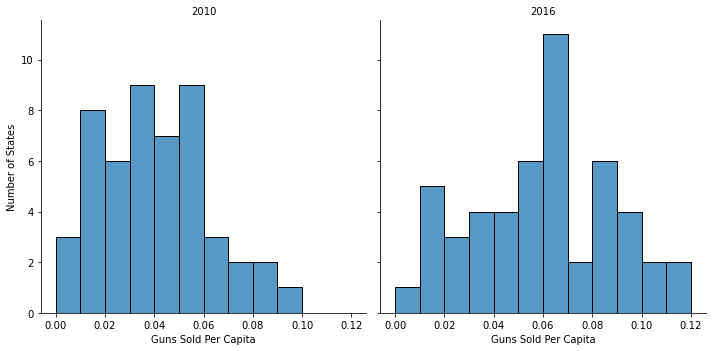

In [56]:
bin_size = 0.01
bins = np.arange(0, per_capita['sales_per_capita'].max()+bin_size, bin_size)
g = sb.displot(data=per_capita, x='sales_per_capita', col='year', bins=bins)
g.set_titles('{col_name}')
g.set_axis_labels('Guns Sold Per Capita', 'Number of States');

Guns sold per capita seem to have increased from 2010 to 2016 as well, given that the histogram for 2016 has more values towards the right side of the distribution compared to 2010. Interestingly, there are no outliers here, indicating that the two outlier states from the previous visualization must have had particularly low proportions of sales among all of the background checks.

### Question 2: What is the overall trend of background checks split by gun category?

I am curious to see the trend of each individual category, specifically for handguns, long guns, and multiple-gun background checks. Again, I will first create yearly and monthly views, then show each category per capita.

In [57]:
gun_checks_yearly = gun_df_full_years.groupby('year')[['handgun', 'long_gun', 'multiple']].sum()
gun_checks_yearly.head()

,handgun,long_gun,multiple
year,,,
1999-01-01,2532511.0,5216320.0,103669.0
2000-01-01,2187581.0,4778762.0,95681.0
2001-01-01,2161166.0,4941982.0,96984.0
2002-01-01,1838239.0,4407866.0,92892.0
2003-01-01,1844597.0,4381438.0,99034.0


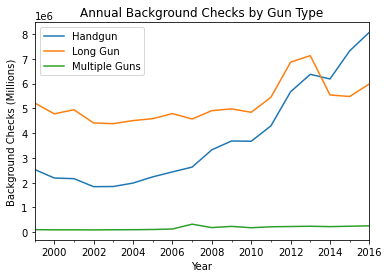

In [58]:
gun_checks_yearly.plot()
gun_checks_types = ['Handgun', 'Long Gun', 'Multiple Guns']
plt.legend(gun_checks_types)
plot_labels('Annual Background Checks by Gun Type', 'Year', 'Background Checks (Millions)');

Although there have typically been more long gun background checks in the historical data, handgun background checks increased at a faster rate and surpassed long guns in 2014. Except for a brief spike in 2012-2013, long gun checks only had a small increase. Multiple-gun checks stayed consistent over the time period.

In [59]:
gun_checks_monthly = gun_df.groupby('month')[['handgun', 'long_gun', 'multiple']].sum()
gun_checks_monthly.head()

,handgun,long_gun,multiple
month,,,
1998-11-01,6858.0,11908.0,275.0
1998-12-01,212737.0,570774.0,8436.0
1999-01-01,184192.0,309818.0,7494.0
1999-02-01,232172.0,352344.0,9221.0
1999-03-01,240680.0,376686.0,9529.0


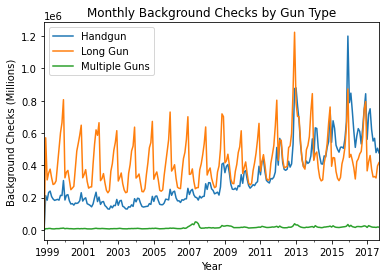

In [60]:
gun_checks_monthly.plot()
plt.legend(gun_checks_types)
plot_labels('Monthly Background Checks by Gun Type', 'Year', 'Background Checks (Millions)');

Handguns and long guns show the same cyclical trends within each year as mentioned previously. However, this trend is not as noticeable in the multiple-gun transactions.

Next, I will create a dataframe similar to the one above that has background checks per capita, but this one will also include `gun_type` as a variable. The goal is to create faceted histograms by `gun_type` and `year`.

In [61]:
gun_type_checks = gun_2010_2016.groupby(['state', 'year'], as_index=False)[['handgun', 'long_gun', 'multiple']].sum()
# rename the gun types to prepare for unpivoting
gun_type_checks.rename(columns={
    'handgun': 'Handgun',
    'long_gun': 'Long Gun',
    'multiple': 'Multiple Guns'
}, inplace=True)
gun_type_checks['year'] = gun_type_checks['year'].dt.year
# unpivot the data
gun_type_checks = pd.melt(gun_type_checks, id_vars=['state', 'year'], var_name='gun_type', value_name='checks')
gun_type_checks.head()

,state,year,gun_type,checks
0,Alabama,2010,Handgun,116963.0
1,Alabama,2016,Handgun,153123.0
2,Alaska,2010,Handgun,25720.0
3,Alaska,2016,Handgun,37491.0
4,Arizona,2010,Handgun,89162.0


In [62]:
type_per_capita = gun_type_checks.merge(population, how='inner', on=['state', 'year'])
type_per_capita['checks_per_capita'] = type_per_capita['checks']/type_per_capita['population']
type_per_capita.head()

,state,year,gun_type,checks,population,checks_per_capita
0,Alabama,2010,Handgun,116963.0,4780131.0,0.024469
1,Alabama,2010,Long Gun,136519.0,4780131.0,0.028560
2,Alabama,2010,Multiple Guns,5465.0,4780131.0,0.001143
3,Alabama,2016,Handgun,153123.0,4863300.0,0.031485
4,Alabama,2016,Long Gun,121963.0,4863300.0,0.025078


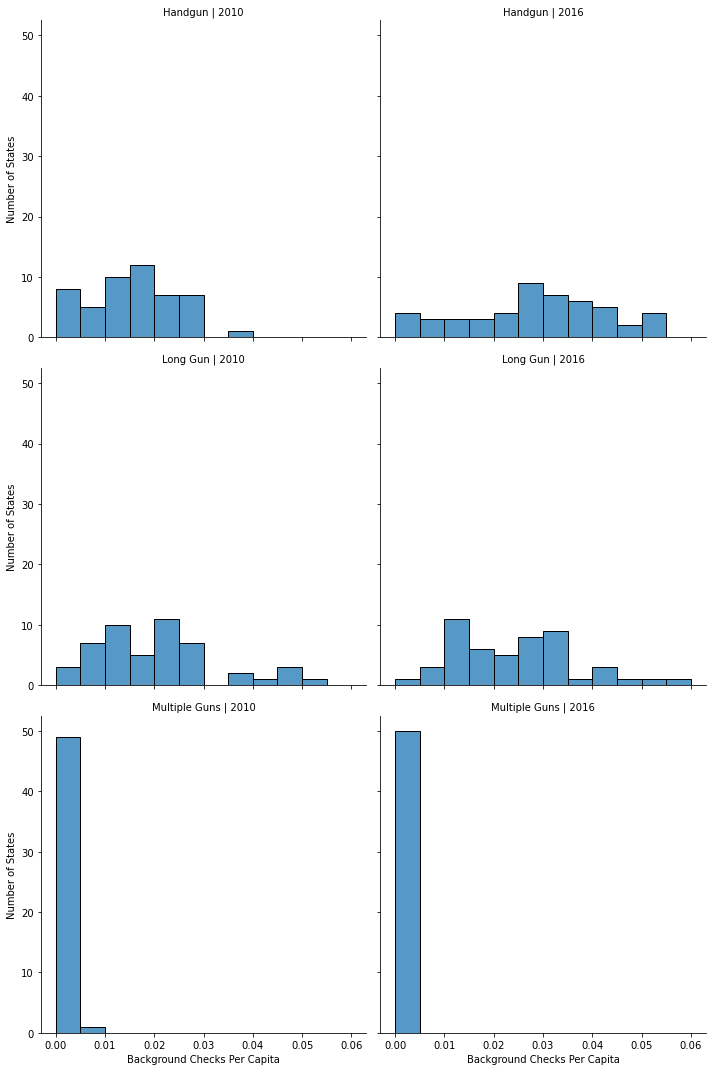

In [63]:
bin_size = 0.005
bins = np.arange(0, type_per_capita['checks_per_capita'].max()+bin_size, bin_size)
g = sb.displot(data=type_per_capita, x='checks_per_capita', row='gun_type', col='year', bins=bins)
g.set_titles('{row_name} | {col_name}')
g.set_axis_labels('Background Checks Per Capita', 'Number of States');

Handgun background checks appear to have increased from 2010 to 2016, as there are more states towards the right side of the distribution for 2016 handgun compared to 2010. However, for long gun and multiple guns, it is difficult to see any noticeable increase from 2010 to 2016.

### Question 3: Which states have had the largest overall and largest growth in background checks per capita?

I will find the top 10 states in 2010, the top 10 states in 2016, and the top 10 growing states between 2010 and 2016. I can do this by pivoting the `per_capita` dataframe from before.

In [64]:
# pivot the data
per_capita_pivot = per_capita.groupby(['state', 'year'])['checks_per_capita'].max().unstack()
per_capita_pivot = per_capita_pivot.reset_index().rename_axis(None, axis=1)
per_capita_pivot.rename(columns={2010: 'per_capita_2010', 2016: 'per_capita_2016'}, inplace=True)
per_capita_pivot.head()

,state,per_capita_2010,per_capita_2016
0,Alabama,0.064560,0.126858
1,Alaska,0.092797,0.118140
2,Arizona,0.032234,0.060060
3,Arkansas,0.065654,0.089020
4,California,0.021914,0.060565


Now I can sort the columns in the new `per_capita_pivot` dataframe to find top 10 states.

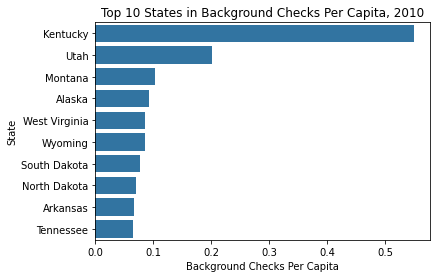

In [65]:
per_capita_2010 = per_capita_pivot.sort_values('per_capita_2010', ascending=False).head(10)
base_color = sb.color_palette()[0]
sb.barplot(data=per_capita_2010, x='per_capita_2010', y='state', color=base_color)
plot_labels('Top 10 States in Background Checks Per Capita, 2010', 'Background Checks Per Capita', 'State');

In 2010, Kentucky had the highest background checks per capita, beating the next highest by more than 0.3 checks per capita. The next highest was Utah, and the rest of the top 10 were at about the same level.

Now I will create a similar visualization using 2016 data.

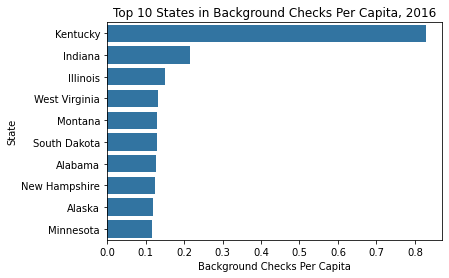

In [66]:
per_capita_2016 = per_capita_pivot.sort_values('per_capita_2016', ascending=False).head(10)
sb.barplot(data=per_capita_2016, x='per_capita_2016', y='state', color=base_color)
plot_labels('Top 10 States in Background Checks Per Capita, 2016', 'Background Checks Per Capita', 'State');

Again, Kentucky had the highest background checks per capita in 2016, with 0.6 more than the next highest, which was Indiana. Similar to 2010, the rest of the top 10 were at about the same level.

Finally, I will calculate the top 10 growing states in background checks per capita by subtracting the per capita values in 2010 from the per capita values in 2016. This will show which states grew the most in background checks per capita.

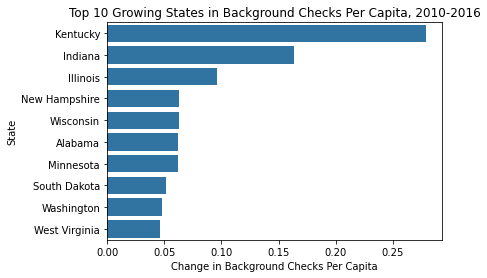

In [67]:
per_capita_pivot['per_capita_growth'] = per_capita_pivot['per_capita_2016']-per_capita_pivot['per_capita_2010']
per_capita_growth = per_capita_pivot.sort_values('per_capita_growth', ascending=False).head(10)
sb.barplot(data=per_capita_growth, x='per_capita_growth', y='state', color=base_color)
plot_labels(
    'Top 10 Growing States in Background Checks Per Capita, 2010-2016',
    'Change in Background Checks Per Capita',
    'State'
);

Kentucky once again had the highest growth from 2010 to 2016, with Indiana and Illinois also showing noticeably higher growth than the rest of the top 10.

### Question 4: What demographic data correlates with background checks per capita by state?

I will look at this question using several demographic variables, including race, veteran status, immigrant status, education level, income, and population density. Many of the variables that I would like to use are in the `census_df` and `per_capita_pivot` dataframes, so I will leverage those by merging them into one dataset.

In [68]:
scatter_df = census_df.copy()
scatter_df = scatter_df.merge(per_capita_pivot, how='inner', on='state')
scatter_df.head()

,state,population_2016,population_2010,white,veterans,immigrants,hs_graduates,bachelors_graduates,median_income,per_capita_income,population_density,per_capita_2010,per_capita_2016,per_capita_growth
0,Alabama,4863300.0,4780131.0,0.693,363170.0,0.035,0.843,0.235,43623.0,24091.0,94.4,0.064560,0.126858,0.062297
1,Alaska,741894.0,710249.0,0.661,69323.0,0.074,0.921,0.280,72515.0,33413.0,1.2,0.092797,0.118140,0.025342
2,Arizona,6931071.0,6392301.0,0.833,505794.0,0.135,0.860,0.275,50255.0,25848.0,56.3,0.032234,0.060060,0.027826
3,Arkansas,2988248.0,2916025.0,0.794,220953.0,0.047,0.848,0.211,41371.0,22798.0,56.0,0.065654,0.089020,0.023366
4,California,39250017.0,37254522.0,0.727,1777410.0,0.270,0.818,0.314,61818.0,30318.0,239.1,0.021914,0.060565,0.038651


A couple of the variables have data for 2010 or 2016, so I can use the corresponding 2010 or 2016 total population as the denominator. However, many of the variables cover the period of 2011-2015. In these cases, I will use the 2010 population in the denominator as an estimate. Similarly, to calculate the background checks per capita, I will look at the total number of background checks over the same period of 2011-2015, and then divide that by the 2010 population. I will print out `census_df_dict` so I know the time period that each variable covers.

In [69]:
census_df_dict

state                                                                                         Fact
population_2016                                       Population estimates, July 1, 2016,  (V2016)
population_2010                                 Population estimates base, April 1, 2010,  (V2016)
white                                                 White alone, percent, July 1, 2016,  (V2016)
veterans                                                                       Veterans, 2011-2015
immigrants                                                Foreign born persons, percent, 2011-2015
hs_graduates           High school graduate or higher, percent of persons age 25 years+, 2011-2015
bachelors_graduates       Bachelor's degree or higher, percent of persons age 25 years+, 2011-2015
median_income                                 Median household income (in 2015 dollars), 2011-2015
per_capita_income                 Per capita income in past 12 months (in 2015 dollars), 2011-2015
population

In [70]:
gun_2011_2015 = gun_df.query('year >= "2011-01-01" and year <= "2015-01-01"')
gun_2011_2015 = gun_2011_2015.groupby('state')['totals'].sum().reset_index()
gun_2011_2015.rename(columns={'totals': 'checks_2011_2015'}, inplace=True)
gun_2011_2015.head()

,state,checks_2011_2015
0,Alabama,2690152.0
1,Alaska,422189.0
2,Arizona,1596290.0
3,Arkansas,1223785.0
4,California,6642294.0


I will now merge `gun_2011_2015` into `scatter_df` so that I can divide the total background checks in 2011-2015 by the population in 2010.

It is also important to point out that the `veterans` column is measured in total numbers, while all of the others take population into account. I would like to convert `veterans` to percentages so that all of the states are comparable.

In [71]:
scatter_df = scatter_df.merge(gun_2011_2015, how='inner', on='state')
scatter_df['per_capita_2011_2015'] = scatter_df['checks_2011_2015']/scatter_df['population_2010']
# veterans column shows totals so find percentages
scatter_df['veterans'] = scatter_df['veterans']/scatter_df['population_2010']
scatter_df.drop(['population_2016', 'population_2010', 'per_capita_growth', 'checks_2011_2015'], axis=1, inplace=True)
scatter_df.head()

,state,white,veterans,immigrants,hs_graduates,bachelors_graduates,median_income,per_capita_income,population_density,per_capita_2010,per_capita_2016,per_capita_2011_2015
0,Alabama,0.693,0.075975,0.035,0.843,0.235,43623.0,24091.0,94.4,0.064560,0.126858,0.562778
1,Alaska,0.661,0.097604,0.074,0.921,0.280,72515.0,33413.0,1.2,0.092797,0.118140,0.594424
2,Arizona,0.833,0.079125,0.135,0.860,0.275,50255.0,25848.0,56.3,0.032234,0.060060,0.249721
3,Arkansas,0.794,0.075772,0.047,0.848,0.211,41371.0,22798.0,56.0,0.065654,0.089020,0.419676
4,California,0.727,0.047710,0.270,0.818,0.314,61818.0,30318.0,239.1,0.021914,0.060565,0.178295


Now I can create a scatter plot showing the white population vs. background checks per capita. I will also add the corresponding Pearson correlation coefficient to show the strength of the relationship between the two variables.

Since I will be creating several of these data visualizations, I will define a function that performs the above steps.

In [72]:
def plot_scatter_corr(x, y, xpos, ypos):
    '''
    INPUT:
    x (str) - x-variable in the scatter plot
    y (str) - y-variable in the scatter plot
    xpos (float) - x-position of the correlation label on the plot
    ypos (float) - y-position of the correlation label on the plot
    
    Print scatter plot with Pearson correlation coefficient at the specified position.
    '''
    
    r, p = pearsonr(scatter_df[x], scatter_df[y])
    fig, ax = plt.subplots()
    # place correlation coefficient label at specified position
    ax.text(xpos, ypos, 'r = {:0.3f}'.format(r), transform=ax.transAxes)
    plt.scatter(data=scatter_df, x=x, y=y)

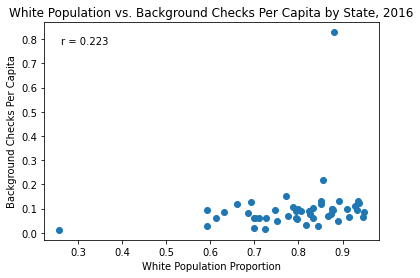

In [73]:
# white column has data for 2016
plot_scatter_corr('white', 'per_capita_2016', 0.05, 0.90)
plot_labels(
    'White Population vs. Background Checks Per Capita by State, 2016',
    'White Population Proportion',
    'Background Checks Per Capita'
)

The data shows that states with higher proportions of white individuals tend to have higher background checks per capita.

The next variable is `veterans`.

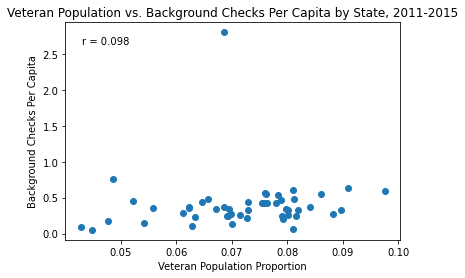

In [74]:
# veterans column has data for 2011-2015
plot_scatter_corr('veterans', 'per_capita_2011_2015', 0.05, 0.90)
plot_labels(
    'Veteran Population vs. Background Checks Per Capita by State, 2011-2015',
    'Veteran Population Proportion',
    'Background Checks Per Capita'
);

Since the correlation coefficient is so small on this graph, it is difficult to make a conclusion on the relationship between the proportion of veterans and background checks per capita.

Now I will look at `immigrants`.

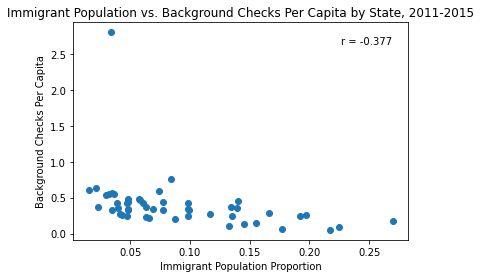

In [75]:
# immigrants column has data for 2011-2015
plot_scatter_corr('immigrants', 'per_capita_2011_2015', 0.80, 0.90)
plot_labels(
    'Immigrant Population vs. Background Checks Per Capita by State, 2011-2015',
    'Immigrant Population Proportion',
    'Background Checks Per Capita'
);

States with lower proportions of immigrants tend to have higher background checks per capita.

Next, I will examine education demographics by looking at columns `hs_graduates` and `bachelors_graduates`.

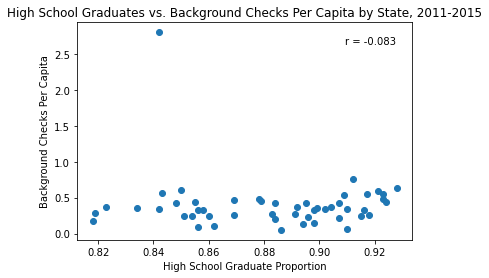

In [76]:
# hs_graduates column has data for 2011-2015
plot_scatter_corr('hs_graduates', 'per_capita_2011_2015', 0.80, 0.90)
plot_labels(
    'High School Graduates vs. Background Checks Per Capita by State, 2011-2015',
    'High School Graduate Proportion',
    'Background Checks Per Capita'
);

The correlation coefficient on this graph is also small, so it is difficult to make a judgment on the relationship between high school graduates and background checks per capita.

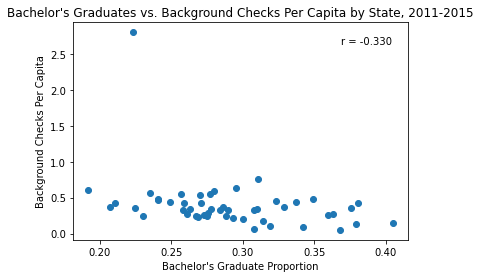

In [77]:
# bachelors_graduates column has data for 2011-2015
plot_scatter_corr('bachelors_graduates', 'per_capita_2011_2015', 0.80, 0.90)
plot_labels(
    "Bachelor's Graduates vs. Background Checks Per Capita by State, 2011-2015",
    "Bachelor's Graduate Proportion",
    'Background Checks Per Capita'
);

States with lower proportions of bachelor's degree graduates tend to have higher background checks per capita.

Now I will explore economic demographics by looking at columns `median_income` and `per_capita_income`.

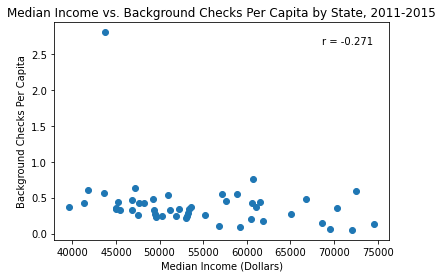

In [78]:
# median_income columns has data for 2011-2015
plot_scatter_corr('median_income', 'per_capita_2011_2015', 0.80, 0.90)
plot_labels(
    'Median Income vs. Background Checks Per Capita by State, 2011-2015',
    'Median Income (Dollars)',
    'Background Checks Per Capita'
);

States with lower median incomes tend to have higher background checks per capita.

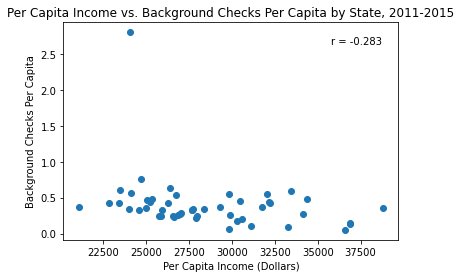

In [79]:
# per_capita_income column has data for 2011-2015
plot_scatter_corr('per_capita_income', 'per_capita_2011_2015', 0.80, 0.90)
plot_labels(
    'Per Capita Income vs. Background Checks Per Capita by State, 2011-2015',
    'Per Capita Income (Dollars)',
    'Background Checks Per Capita'
);

Similar to median income, states with lower per capita income tend to have higher background checks per capita.

The last variable to look at is `population_density`.

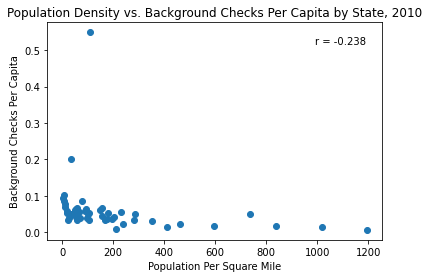

In [80]:
# population_density column has data for 2010
plot_scatter_corr('population_density', 'per_capita_2010', 0.80, 0.90)
plot_labels(
    'Population Density vs. Background Checks Per Capita by State, 2010',
    'Population Per Square Mile',
    'Background Checks Per Capita'
);

States with lower population density have higher background checks per capita, meaning that guns seem to be more popular in rural areas.

<a id='conclusions'></a>
## Conclusions
### Results

All findings presented here are tentative. I have only explored correlations and am not implying any causation.

In my analysis, I examined the following four questions:
- What is the overall trend of background checks and gun sales?
- What is the overall trend of background checks split by gun category?
- Which states have had the largest overall and largest growth in background checks per capita?
- What demographic data correlates with background checks per capita by state?

The overall trend of background checks and gun sales (for handguns, long guns, and multiple-gun sales, specifically) increased since the data was first collected. The number of annual background checks increased by almost 20 million per year, while the number of gun sales increased by about 8 million per year.

Interestingly, though, the increase in background checks and gun sales were not steady within each year. Rather, these metrics underwent cyclical rises and falls based on the time of the year. The peak in background checks and gun sales usually happened around the end of each year.

However, I also wanted to make sure that the increase was not solely due to an increase in population. Therefore, I decided to look at the distributions of background checks and gun sales per capita from 2010 to 2016 to see if there was any change. For both metrics, there was an increase, as the 2016 distributions were less right-skewed compared to 2010.

The number of long gun background checks historically was higher than the number of handgun checks until 2014, when handguns finally surpassed long guns. Both handgun and long gun background checks increased over the data collection period, but handguns increased at a faster rate than long guns. Meanwhile, multiple-gun background checks were less common and stayed relatively steady over the time period that the data was collected.

Within each year, handgun and long gun background checks showed the same cyclical trends as mentioned previously. This trend was not as pronounced for multiple-gun checks.

In terms of per capita measures, the distribution of handgun background checks per capita showed an increase in this gun type from 2010 to 2016. Meanwhile, the differences between 2010 and 2016 distributions for long gun and multiple-gun background checks per capita were less noticeable.

In 2010, the state with the highest background checks per capita by about 0.3 checks per capita was Kentucky. The next highest was Utah at 0.2, and the rest of the top 10 were at about the same level. In 2016, the state with the highest measure was again Kentucky, leading the second highest by about 0.6 checks per capita. The second highest was Indiana at 0.2, and again the rest of the top 10 were at about the same level. I also wanted to see the fastest growing states, measured by the difference in background checks per capita from 2010 to 2016. The leader was again Kentucky with an increase of more than 0.25 checks per capita. Other fast-growing states were Indiana with an increase of more than 0.15 and Illinois with an increase of about 0.1.

The five states that made the top 10 in both 2010 and 2016 were Kentucky, Montana, Alaska, West Virginia, and South Dakota. The only three states out of these five that were also in the top 10 in growth were Kentucky, West Virginia, and South Dakota.

Most of the demographic variables that I looked at gave indication of some correlation between the demographics and background checks per capita, even if the correlation was not strong based on the correlation coefficient. The two variables with weaker correlations were veteran population and high school graduates. Without Kentucky, which had much higher background checks per capita, the correlation coefficients probably would have been higher. However, I did not remove Kentucky since it is still an important data point.

Looking at the other demographic variables, background checks per capita tended to be higher in states with a higher proportion of white individuals, lower proportion of immigrants and bachelor's degree graduates, lower median and per capita income, and lower population density.

### Limitations
One limitation of this analysis is that the NICS data does not account for private gun sales, which do not require background checks. According to BuzzFeed News via The Trace, about 40% of respondents in a survey said that they had acquired their most recent firearm in a private sale. If this private sales data were available, it would provide a more holistic view of US gun transactions.

Another limitation is that the census data only provides metrics for certain years, such as the percentage of white individuals in 2016 or the number of veterans in 2011-2015. Having data on more years would have improved the analysis in several ways. First, it would have allowed for more consistent comparisons across different variables, such as looking at the correlations of background checks per capita with white and veteran populations, both in 2016. Additionally, more years in the census data would have allowed me to look across longer periods of time. When looking at background checks per capita, I was only able to compare 2010 to 2016 because only the populations for those two years were provided. It would have been more interesting, however, to see how background checks per capita changed since 1998, when the gun data was first collected. Another benefit of more census data is that it could provide a better denominator for some of the metrics. To calculate background checks per capita in 2011-2015, for instance, I ended up using 2010 as the denominator because there were no populations provided for 2011-2015. Although this provides a reasonable estimate, it would have been more accurate if the data for more years was included. Finally, more data would be beneficial in adding more data points to each of the scatter plots, which in turn could show whether the same trends have been truly been consistent over the years.

<a id='sources'></a>
## Sources

- [NICS Firearm Background Checks](https://www.fbi.gov/file-repository/nics_firearm_checks_-_month_year_by_state_type.pdf/view)
- [BuzzFeed News GitHub Repository](https://github.com/BuzzFeedNews/nics-firearm-background-checks/blob/master/README.md)
- [Remove ellipsis from Jupyter notebook output](https://stackoverflow.com/questions/32075022/python-pandas-how-can-i-avoid-ellipsis-when-using-describe)
- [Display rows with NaN values](https://stackoverflow.com/questions/43424199/display-rows-with-one-or-more-nan-values-in-pandas-dataframe)
- [Transpose](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transpose.html)
- [Reset index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html#pandas.DataFrame.reset_index)
- [String endswith() function](https://www.programiz.com/python-programming/methods/string/endswith)
- [Extract year from datetime](https://stackoverflow.com/questions/30405413/python-pandas-extract-year-from-datetime-dfyear-dfdate-year-is-not)
- [Convert year integer to datetime](https://stackoverflow.com/questions/46658232/pandas-convert-column-with-year-integer-to-datetime)
- [Check data types](https://stackoverflow.com/questions/16488278/how-to-check-if-a-variable-is-an-integer-or-a-string/16488375)
- [Text boxes in Matplotlib](https://matplotlib.org/3.1.1/gallery/recipes/placing_text_boxes.html)